# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
# Your code here.
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100, CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
import torch
from tqdm import tqdm
import wandb
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class CIFAR100_wrapper(Dataset):

    def __init__(self, classes: set[int], get_train: bool = True) -> None:
        super().__init__()
        self.classes = classes
        cifar = CIFAR100("~/datasets", download=get_train, train=get_train, transform=Compose([ToTensor()]))
        samples = []
        labels = []
        for i in range(len(cifar)):
            if cifar[i][1] in classes:
                samples.append(cifar[i][0])
                labels.append(torch.Tensor([cifar[i][1]]).long())
        self.data = torch.stack(samples)
        self.labels = torch.cat(labels)

    def __len__(self): return len(self.labels)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]: return self.data[index], self.labels[index]

index_id = set(range(20))
index_ood = set(range(30, 40))

batch_size=64

c20 = CIFAR100_wrapper(index_id)
c20_train, c20_val = random_split(c20, [0.7, 0.3])
c20_test = CIFAR100_wrapper(index_id)
c20_ood = CIFAR100_wrapper(index_ood)
dl_train = DataLoader(c20_train, batch_size, shuffle=True)
dl_val = DataLoader(c20_val, batch_size, shuffle=True)
dl_test = DataLoader(c20_test, batch_size, shuffle=True)
dl_ood = DataLoader(c20_ood, batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
@torch.no_grad()
def ood_test(model, dataloader):
    max_logits = []
    second_guess = []
    for x, _ in dataloader:
        x = x.to(device)
        logits_sorted, _ = torch.sort(model(x), descending=True)
        max_logits.append(logits_sorted[:, 0])
        second_guess.append(logits_sorted[:, 1])
    max_logits = torch.cat(max_logits)
    second_guess = torch.cat(second_guess)
    return (max_logits - second_guess)

# Model (note for me: OK)
A simple model for classification

In [4]:
class CifarClassifier(nn.Module):

    def __init__(self, n_classes) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
        self.dropout1 = nn.Dropout()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2)
        self.dropout2 = nn.Dropout()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(nn.Linear(784*2, 1000), nn.ReLU(), nn.Linear(1000, n_classes))

    def forward(self, X):
        X = F.relu(self.dropout1(self.conv1(X)))
        X = self.pool1(X)
        X = F.relu(self.dropout2(self.conv2(X)))
        X = self.pool2(X)
        X = self.flatten(X)
        return self.head(X)


In [16]:
def conv_3x3_same_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU()
    )

def conv_3x3_valid_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
        nn.MaxPool2d(3, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(), 
        nn.Dropout(0.3)
    )

class RCNN(nn.Module): 
    def __init__(self, res, input_channels, embedding_filters, depth, n_classes) -> None:
        super(RCNN, self).__init__()
        self.input = nn.Sequential(*[
            conv_3x3_valid_block(input_channels, embedding_filters // 4), 
            conv_3x3_valid_block(embedding_filters // 4, embedding_filters // 2), 
            conv_3x3_valid_block(embedding_filters // 2, embedding_filters)
        ])
        self.net = nn.ModuleList([
            conv_3x3_same_block(embedding_filters, embedding_filters)
        for _ in range(depth)])
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(((res - 12) ** 2) * embedding_filters, n_classes)
        )
    def forward(self, X):
        X = self.input(X)
        for layer in self.net:
            X = X + layer(X)
        return self.out(X)

# Remove?

In [ ]:
import torch.nn as nn
class SimpleCNN(nn.Module):

    def __init__(self, res, input_channels, embedding_channels, n_convs, n_classes) -> None:
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(input_channels, embedding_channels, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(3, stride=1))
        self.net = nn.Sequential(*[
            nn.Sequential(nn.Conv2d(embedding_channels, embedding_channels, kernel_size=3, padding=1), nn.LayerNorm((embedding_channels, res-2, res-2)), nn.ReLU())
        ], nn.MaxPool2d(3, stride=1))
        self.head = nn.Linear(((res-4)**2) * embedding_channels, n_classes)

    def forward(self, X):
        X = self.input(X)
        X = self.net(X)
        return self.head(X.flatten(1))

# CIFAR10 dataset

In [5]:
cifar = CIFAR10("~/datasets", transform=Compose([ToTensor() # ,
     # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))
c_train, c_val = random_split(cifar, [0.7, 0.3])
dl_train = DataLoader(c_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(c_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(CIFAR10("~/datasets", train=False, transform=ToTensor()), batch_size=batch_size, shuffle=True)

In [9]:
n_classes = 10
res = 32
i_channels = 3
e_channels = 32
n_convs = 16
# model = RCNN(res, i_channels, e_channels, n_convs, n_classes).to(device)
model = CifarClassifier(n_classes).to(device)
x = torch.rand((16, 3, 32, 32)).to(device)
model(x).shape

torch.Size([16, 10])

## Training

In [6]:
@torch.no_grad()
def validation(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

In [7]:
def training(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [10]:
loss_fn = F.cross_entropy
epochs = 50
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lss, accs = training(model, dl_train, dl_val, loss_fn, optim, epochs, 2, False)

Loss Train = 1.2582853930088023, Loss Val = 1.5111638302498676, Acc = 0.5534666666666667


Loss Train = 1.026133086171403, Loss Val = 1.334237082968367, Acc = 0.5871333333333333


Loss Train = 0.862143897487215, Loss Val = 1.180529312884554, Acc = 0.6416666666666667


Loss Train = 0.713940175730306, Loss Val = 1.161066206719013, Acc = 0.6268


Loss Train = 0.5835788519116599, Loss Val = 1.0642729371152027, Acc = 0.6467333333333334


Loss Train = 0.48246948786039023, Loss Val = 1.0284766625850759, Acc = 0.6541333333333333


Loss Train = 0.38839499984733367, Loss Val = 1.0284387923301535, Acc = 0.6491333333333333


Loss Train = 0.31942346041010766, Loss Val = 0.9996684660302831, Acc = 0.6516


Loss Train = 0.2719133257920389, Loss Val = 0.9760315337079637, Acc = 0.6684


Loss Train = 0.23855519800070651, Loss Val = 0.9918479386796343, Acc = 0.6596


Loss Train = 0.209031419048743, Loss Val = 0.9733963007622577, Acc = 0.6709333333333334


Loss Train = 0.19667510366172852, Loss Val = 1.00215729424294, Acc = 0.6616666666666666


Loss Train = 0.17621932755236325, Loss Val = 1.073248496207785, Acc = 0.6418666666666667


Loss Train = 0.16720844592415546, Loss Val = 1.0475528171721926, Acc = 0.6539333333333334


Loss Train = 0.14647655291874404, Loss Val = 1.1433635435205824, Acc = 0.6363333333333333


Loss Train = 0.1501696029102508, Loss Val = 1.1749899937751445, Acc = 0.6270666666666667


Loss Train = 0.14263986460217556, Loss Val = 1.2117175117452095, Acc = 0.6297333333333334


Loss Train = 0.13301737221737667, Loss Val = 1.1002776528926606, Acc = 0.6550666666666667


Loss Train = 0.11899728097116925, Loss Val = 1.171924316883087, Acc = 0.6486666666666666


Loss Train = 0.12209503391120835, Loss Val = 1.1789639297952044, Acc = 0.6382


Loss Train = 0.117116301523954, Loss Val = 1.1640271115810312, Acc = 0.647


Loss Train = 0.10625386106572242, Loss Val = 1.2360064823576744, Acc = 0.6380666666666667


Loss Train = 0.11047763592126002, Loss Val = 1.3004840505884048, Acc = 0.6224666666666666


Loss Train = 0.10147536778567151, Loss Val = 1.231611638373517, Acc = 0.6364666666666666


Loss Train = 0.10281976368754993, Loss Val = 1.232103065734214, Acc = 0.6431333333333333


In [11]:
id_data = ood_test(model, dl_test)
ood_data = ood_test(model, dl_ood)

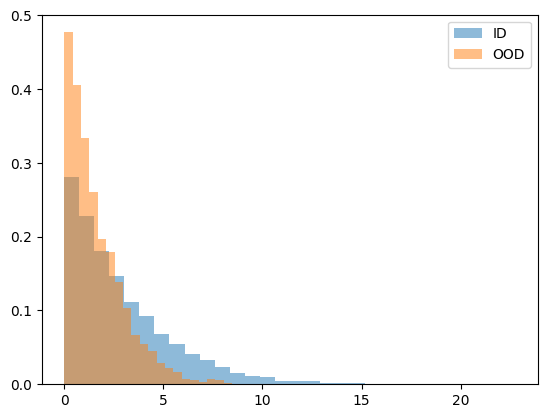

In [13]:
plt.hist(id_data.cpu(), bins=30, density=True, alpha=0.5, label="ID")
plt.hist(ood_data.cpu(), bins=30, density=True, alpha=0.5, label="OOD")
plt.legend()
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [26]:
# Your code here.
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
@torch.no_grad()
def ood_roc_test(model, dataloader):
    predictions = []
    true_values = []
    for x, y in dataloader:
        x = x.to(device)
        logits = model(x)
        predictions.append(logits.argmax(dim=1).cpu())
        true_values.append(y)
    predictions = torch.cat(predictions, dim=0)
    true_values = torch.cat(true_values, dim=0)
    RocCurveDisplay.from_predictions(true_values == 0, predictions == 0)

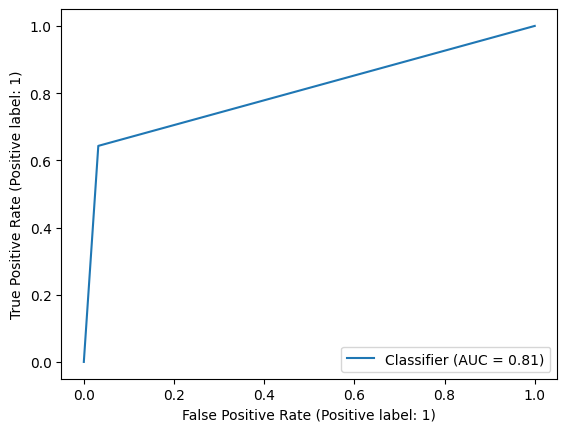

In [27]:
ood_roc_test(model, dl_test)

In [ ]:
def get_recall(prediction, true, ref_class):
    tp = (prediction == true * true == ref_class).sum().float().item()
    fn = (prediction != true * true == ref_class).sum().float().item()
    return tp / (tp + fn)

def get_precision(prediction, true, ref_class):
    tp = (prediction == true * true == ref_class).sum().float().item()
    fp = (prediction == true * true != ref_class).sum().float().item()
    return tp / (tp + fp)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [29]:
r = torch.randn((10)) * 10
r

tensor([ -4.7393,  -0.7077, -20.8036,   7.8925,  11.7796,   8.2283,   6.2811,
         16.0537,  11.1043,   8.1349])

In [32]:
s = r.sign()
s

tensor([-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [20]:
from torch.autograd import Variable
# Your code here.
def fgs_perturbation(model: torch.nn.Module, batch: torch.Tensor, batch_label: torch.Tensor, loss_fn, epsilon: float = 0.01):
    # gradient wrt input
    batch.requires_grad = True
    model.requires_grad_ = False
    logits = model(batch)
    loss = loss_fn(logits, batch_label)
    loss.backward()
    perturbation = batch.grad.data # gradient
    perturbation = perturbation.sign() # signed gradient
    perturbation = epsilon * perturbation # scaled perturbation
    return perturbation

In [11]:
for x, y in dl_train:
    batch, batch_labels = x, y
    break

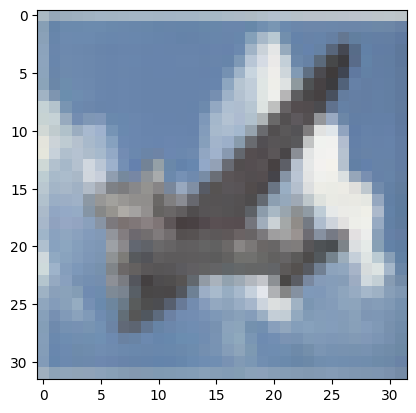

In [133]:
plt.imshow(batch[0].transpose(0, 1).transpose(1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
True
True
True


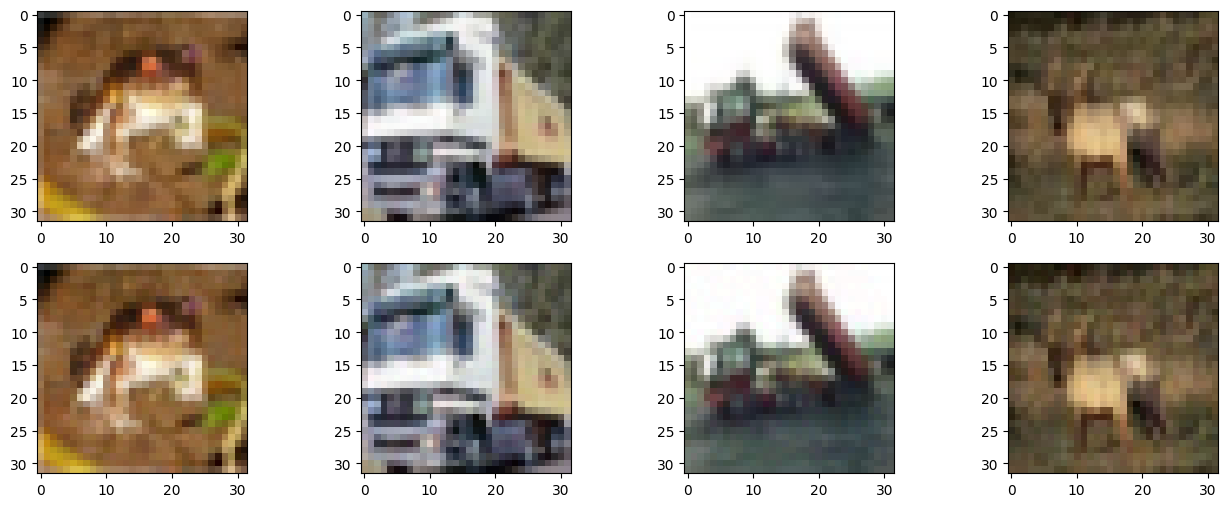

In [12]:
cols = 4
fig, axes = plt.subplots(2, cols, figsize=(16, 6))
for i in range(cols):
    x, y = cifar[i][0].to(device), torch.tensor([cifar[i][1]]).to(device)
    x = x.view(1, *x.shape)
    pert = fgs_perturbation(model, x, y, F.cross_entropy)
    perturbed = x + pert
    perturbed = perturbed[0] 
    x = x[0]
    axes[0][i].imshow(x.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    axes[1][i].imshow(perturbed.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
True
True
True


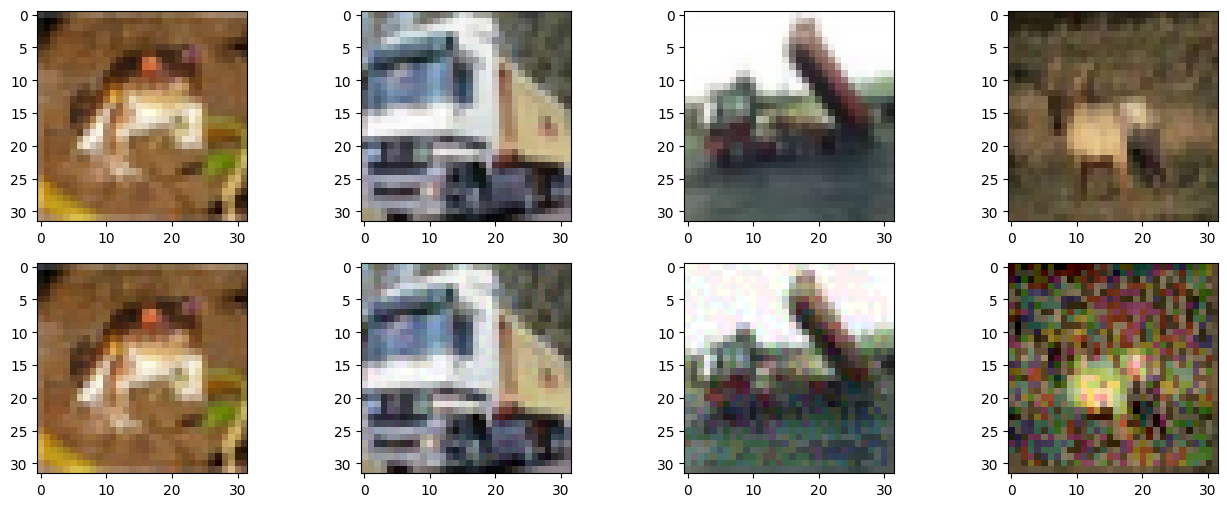

In [13]:
fig, axes = plt.subplots(2, cols, figsize=(16, 6))
epsilons = [0.01, 0.02, 0.05, 0.1]
for i in range(cols):
    x, y = cifar[i][0].to(device), torch.tensor([cifar[i][1]]).to(device)
    x = x.view(1, *x.shape)
    pert = fgs_perturbation(model, x, y, F.cross_entropy, epsilon=epsilons[i])
    perturbed = x + pert
    perturbed = perturbed[0] 
    x = x[0]
    axes[0][i].imshow(x.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    axes[1][i].imshow(perturbed.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.show()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [21]:
# Your code here.
def augment_batch(model, batch, batch_labels, loss, epsilon=0.01):
    pert = fgs_perturbation(model, batch, batch_labels, loss, epsilon)
    augmented_data = batch + pert
    batch = torch.cat([batch, augmented_data], dim=0)
    batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
    return batch, batch_labels

batch, batch_labels = batch.to(device), batch_labels.to(device)
print(batch.requires_grad)
aug, aug_l = augment_batch(model, batch, batch_labels, F.cross_entropy)
print(batch.shape, aug.shape)

True
torch.Size([64, 3, 32, 32]) torch.Size([128, 3, 32, 32])


In [22]:
def training_with_augment(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            x, y = augment_batch(model, x, y, loss_fn)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [23]:
loss_fn = F.cross_entropy
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lss, accs = training_with_augment(model, dl_train, dl_val, loss_fn, optim, 50, 2, False)

Loss Train = 0.1827293416073161, Loss Val = 1.2190107020925969, Acc = 0.6269333333333333


Loss Train = 0.16391916708915172, Loss Val = 1.2051163901673987, Acc = 0.63


Loss Train = 0.14845198674137675, Loss Val = 1.2701540444759611, Acc = 0.6134


Loss Train = 0.13873247593859214, Loss Val = 1.2282768264729926, Acc = 0.6231333333333333


Loss Train = 0.13533446570378227, Loss Val = 1.2572342345055114, Acc = 0.6176


KeyboardInterrupt: 

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
